In [ ]:
!pip install category_encoders
!pip install catboost

In [2]:
import pandas as pd
data = pd.read_csv('/content/Casestudy_Data.csv')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,NaN,-36.4,4.857,5191.0,no


In [3]:
from sklearn.model_selection import train_test_split

X = data.drop(columns='y')
y = data['y'].map({'yes': 1, 'no': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [4]:
from category_encoders import TargetEncoder
from sklearn.preprocessing import LabelEncoder
def perform_target_encoding(X_train, X_test, y_train, y_test, nominal_variables):
        encoder_target = TargetEncoder(cols=nominal_variables)
        X_train[nominal_variables] = encoder_target.fit_transform(X_train[nominal_variables], y_train)
        X_test[nominal_variables] = encoder_target.transform(X_test[nominal_variables], y_test)
        return X_train, X_test

def perform_label_encoding(X_train, X_test, ordinal_variables):
        le = LabelEncoder()
        le_name_mapping = {}
        for col in ordinal_variables:
            X_train[col] = le.fit_transform(X_train[col])
            X_test[col] = le.transform(X_test[col])
            le_name_mapping[col] = dict(zip(le.classes_, le.transform(le.classes_)))
        return X_train, X_test, le_name_mapping

ordinal_features = ['job', 'education', 'housing']
nominal_features = ['marital', 'default', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

X_train_encoded, X_test_encoded = perform_target_encoding(X_train, X_test, y_train, y_test, nominal_features)
X_train_encoded, X_test_encoded, name_mapping = perform_label_encoding(X_train_encoded, X_test_encoded, ordinal_features)

In [5]:
from sklearn.utils import resample
def undersample(X_train, y_train):
        X_train = X_train.reset_index(drop=True)
        y_train = y_train.reset_index(drop=True)

        train_data = pd.concat([X_train, y_train], axis=1)

        majority_class = train_data[train_data['y'] == 0]
        minority_class = train_data[train_data['y'] == 1]

        majority_downsampled = resample(majority_class,
                                        replace=False,
                                        n_samples=len(minority_class),
                                        random_state=42)

        undersampled_data = pd.concat([minority_class.reset_index(drop=True), majority_downsampled.reset_index(drop=True)])

        undersampled_X_train = undersampled_data.drop(columns=['y'])
        undersampled_y_train = undersampled_data['y']
        return undersampled_X_train, undersampled_y_train

X_train_sampled, y_train_sampled = undersample(X_train_encoded, y_train)

In [6]:
from sklearn.preprocessing import StandardScaler
def perform_standard_scaling(X_train, X_test):
        standard_scaler = StandardScaler()
        scaled_X_train = pd.DataFrame(standard_scaler.fit_transform(X_train), columns=X_train.columns)
        scaled_X_test = pd.DataFrame(standard_scaler.transform(X_test), columns=X_test.columns)
        return scaled_X_train, scaled_X_test

X_train_scaled, X_test_scaled = perform_standard_scaling(X_train_sampled, X_test_encoded)

In [7]:
import catboost as cb
def train_catboost_classifier(X_train, y_train):
        clf = cb.CatBoostClassifier()
        clf.fit(X_train, y_train, verbose=False)
        return clf

model = train_catboost_classifier(X_train_sampled, y_train_sampled)

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

y_preds = model.predict(X_test_encoded)

print (classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      7310
           1       0.44      0.95      0.60       928

    accuracy                           0.86      8238
   macro avg       0.72      0.90      0.76      8238
weighted avg       0.93      0.86      0.88      8238



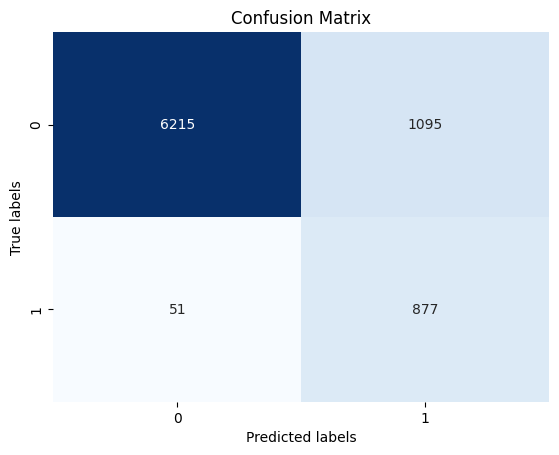

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_preds)

# Plot confusion matrix
plt.figure(figsize=(6.4, 4.8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

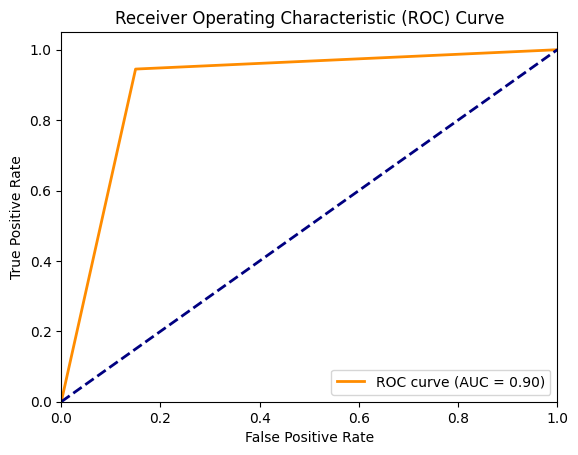

In [16]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_preds)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6.4, 4.8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()